In [116]:
import ast
import random
import pickle
import json

import pandas as pd
import numpy as np
from numpy.linalg.linalg import LinAlgError
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from matplotlib_venn import venn2, venn3, venn3_circles
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2

In [79]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [80]:
ogtt = pd.read_csv(r'..\data\processed\OGTT_fixed_effects_lm_results.csv', index_col=0)
bg = pd.read_csv(r'..\data\processed\Weekly_BG_fixed_effects_lm_results.csv', index_col=0)

In [7]:
# feat = 'unknown_108179688_13387'
feature = "l_218"
def get_lme_params(feature, lme_df):
    """
    Return the three points that define each of Random and Fasted best fit lines for plotting in plt.scatter()
    in the form {'RBG': [[normal_x, impaired_x, diabetic_x], [normal_y, impaired_y, diabetic_y]],
                 'FBG': [[normal_x, impaired_x, diabetic_x], [normal_y, impaired_y, diabetic_y]]}
    """
    # ast = Abstract Syntax Tree
    # This trick reads in an incorrectly formatted dictionary that uses  ''  instead of ""
    # https://stackoverflow.com/questions/988228/convert-a-string-representation-of-a-dictionary-to-a-dictionary
    params = ast.literal_eval(lme_df.loc[feature]['full_model_params'])
    
    diabetic_fbg = params['Intercept']
    diabetic_rbg = params['Intercept'] + params['bg_type[T.RBG]']

    impaired_fbg = diabetic_fbg + params['glucose_tolerance[T.impaired]']
    impaired_rbg = diabetic_rbg + params['glucose_tolerance[T.impaired]'] + params['glucose_tolerance[T.impaired]:bg_type[T.RBG]']

    normal_fbg = diabetic_fbg + params['glucose_tolerance[T.normal]']
    normal_rbg = diabetic_rbg + params['glucose_tolerance[T.normal]'] + params['glucose_tolerance[T.normal]:bg_type[T.RBG]']
    
    return {'RBG': [[0, 1, 2], [normal_rbg, impaired_rbg, diabetic_rbg]],
            'FBG': [[0, 1, 2], [normal_fbg, impaired_fbg, diabetic_fbg]]}  
get_lme_params(feature, ogtt)

KeyError: 'glucose_tolerance[T.impaired]'

In [109]:
ogtt_values = animal_phenotypes.loc[animal_phenotypes['lcms_sampled'], 'OGTT (AUC)']
min_ogtt, max_ogtt = min(ogtt_values), max(ogtt_values)

def get_model_params(feature, df): 
    params = ast.literal_eval(df.loc[feature]['full_model_params'])
    interceptfbg = params['Intercept']
    interceptrbg = interceptfbg + params['bg_type[T.RBG]']
    minfbg = interceptfbg + params['ogtt'] * min_ogtt
    minrbg = interceptrbg + params['ogtt:bg_type[T.RBG]'] * min_ogtt
    maxfbg = interceptfbg + params['ogtt'] * max_ogtt
    maxrbg = interceptrbg + params['ogtt:bg_type[T.RBG]'] * max_ogtt
    
    return {'RBG': [[min_ogtt, max_ogtt], [minrbg, maxrbg]],
            'FBG': [[min_ogtt, max_ogtt], [minfbg, maxfbg]]}  
test = get_model_params('l_222', ogtt)
test

{'RBG': [[846.75, 2321.25], [19.60120932465671, 19.994654801699355]],
 'FBG': [[846.75, 2321.25], [18.95011268332485, 19.465095279545206]]}

In [110]:
data

,Unique ID,Type,Proposed ID,Found in Tracefinder,Compound Class,m/z,RT [min],Area (Max.),Score,Adduct,...,1092_10_FBG,1082_8_RBG,1062_8_RBG,1102_10_FBG,1093_8_RBG,1074_9_FBG,1062_9_RBG,1101_8_RBG,1092_8_RBG,1092_10_RBG
i,,,,,,,,,,,,,,,,,,,,,
l_0,unknown_679.05463_0.536,lipid,unknown,NaN,unknown,679.05463,0.536,24.521584,NaN,NaN,...,22.462249,23.360916,22.399150,23.163419,22.737840,22.116533,23.352451,23.527438,23.858693,23.617549
l_1,unknown_641.1087_0.537,lipid,unknown,NaN,unknown,641.10870,0.537,25.718750,NaN,NaN,...,24.663849,23.700392,23.382317,24.385568,23.789670,22.248759,22.513249,24.558075,24.818525,24.575904
l_2,unknown_951.15973_0.541,lipid,unknown,NaN,unknown,951.15973,0.541,24.948650,NaN,NaN,...,23.452626,22.549975,23.249352,23.680978,23.989589,23.527507,24.002570,23.886203,24.069137,23.455789
l_3,unknown_329.03067_0.542,lipid,unknown,NaN,unknown,329.03067,0.542,28.102881,NaN,NaN,...,27.210668,26.194952,26.911119,26.805997,26.145097,26.638404,27.217392,26.970428,27.175265,26.482705
l_4,unknown_969.13147_0.544,lipid,unknown,NaN,unknown,969.13147,0.544,24.016735,NaN,NaN,...,22.602208,21.905509,22.226570,22.485669,22.208159,22.236114,23.151359,22.823820,21.750593,22.047030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_169,unknown_174.00102_9.94,metabolite,unknown,NaN,unknown,174.00102,9.940,25.488336,NaN,[M-H]-1,...,24.942889,24.895636,24.931289,25.067714,25.395219,24.788981,24.894367,25.168366,25.050323,24.771208
m_213,unknown_187.04097_9.971,metabolite,unknown,NaN,unknown,187.04097,9.971,25.075584,52.5,[M-H]-1,...,20.484062,23.047250,23.625874,20.663426,20.698623,20.921984,24.008593,22.538237,21.117720,18.221881
m_24,DL-Lactic Acid_89.02331_9.99,metabolite,DL-Lactic Acid,NaN,CA,89.02331,9.990,28.683584,99.9,[M-H]-1,...,27.236489,27.782425,27.946315,27.362929,27.223422,27.298238,28.052793,27.463850,27.304277,26.282341


## 

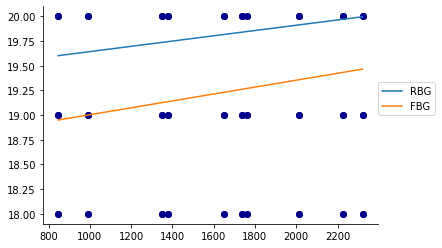

In [117]:
animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

feature = 'l_222'

fig, ax = plt.subplots()
params = get_model_params(feature, ogtt)

for bg_type, bg_color in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']]):
    ax.plot(params[bg_type][0], params[bg_type][1], label=bg_type)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        plt.scatter([animal_ogtt]*3, np.arange(18, 21, 1), color='darkblue')
                    # )
plt.legend(loc=(1, 0.5))
sns.despine()

In [50]:
data.loc[feature, fbg_cols]

1076_10_FBG    19.824659
1062_8_FBG     20.084716
1093_9_FBG     20.346424
1091_10_FBG    20.595886
1082_10_FBG    20.443414
1101_9_FBG     20.742727
1074_10_FBG    20.704532
1076_9_FBG      20.69551
1092_9_FBG     20.644839
1074_8_FBG     21.881693
1082_9_FBG     20.320467
1060_8_FBG     20.468028
1060_10_FBG    20.438615
1101_10_FBG    20.321229
1093_8_FBG     20.327071
1062_9_FBG     20.310833
1092_8_FBG     20.695642
1062_10_FBG     20.01034
1060_9_FBG     20.347899
1091_9_FBG      21.61014
1102_9_FBG      20.55769
1093_10_FBG    20.452957
1101_8_FBG     20.411847
1102_8_FBG     20.269157
1082_8_FBG     20.556092
1076_8_FBG     20.956855
1091_8_FBG     19.942237
1092_10_FBG    20.397387
1102_10_FBG    20.130615
1074_9_FBG     20.600043
Name: l_218, dtype: object

In [59]:
f.filter(regex='1076').mean(axis=1)

i
l_0      22.679690
l_1      23.594023
l_2      23.103339
l_3      26.243724
l_4      21.424737
           ...    
m_169    24.689008
m_213    20.310409
m_24     26.922636
m_505    19.534830
m_441    22.116884
Length: 1727, dtype: float64

In [63]:
d = {'RBG': {}, 'FBG': {}}

for animal in animals_used:
    for df, bg_type in zip([f, r], ['FBG', 'RBG']):
        bg_type_animal_mean = df.filter(regex=str(animal)).mean(axis=1)
        d['RBG'][animal] = bg_type_animal_mean 

In [75]:
animal_ogtt = {animal: ogtt for animal, ogtt in zip(animal_phenotypes['animal'], animal_phenotypes['OGTT (AUC)'])}
animal_ogtt

{1060: 1761.75,
 1061: 1674.8,
 1062: 1648.75,
 1063: nan,
 1074: 1350.25,
 1075: 3365.0,
 1076: 2321.25,
 1080: nan,
 1081: 2354.75,
 1082: 2224.75,
 1091: 846.75,
 1092: 1377.95,
 1093: 993.0,
 1094: 842.75,
 1095: nan,
 1096: 1401.25,
 1100: nan,
 1101: 2015.75,
 1102: 1738.25}

In [76]:
d['RBG'][1101]['l_0']

23.527160843441468

In [77]:
metab_ogtt_animal = {}
for metab in data.index:
    metab_ogtt_animal[metab] = 
    

l_0
l_1
l_2
l_3
l_4
l_5
l_6
l_7
l_8
l_9
l_10
l_11
l_12
l_13
l_14
l_15
l_16
l_17
l_18
l_19
l_20
l_21
l_24
l_22
l_23
l_25
l_26
l_28
l_27
l_29
l_30
l_33
l_31
l_32
l_35
l_34
l_36
l_37
l_38
l_39
l_40
l_41
l_42
l_43
l_44
l_45
l_46
l_47
l_48
l_49
l_50
l_51
l_52
l_53
l_54
l_55
l_56
l_57
l_58
l_59
l_60
l_61
l_62
l_63
l_64
l_65
l_66
l_67
l_68
l_69
l_70
l_71
l_72
l_73
l_74
l_75
l_77
l_76
l_79
l_78
l_80
l_81
l_82
l_83
l_84
l_85
l_86
l_87
l_88
l_89
l_90
l_91
l_92
l_93
l_94
l_95
l_96
l_97
l_98
l_99
l_100
l_101
l_102
l_103
l_104
l_105
l_106
l_107
l_108
l_109
l_110
l_111
l_112
l_113
l_114
l_115
l_116
l_117
l_120
l_119
l_118
l_121
l_122
l_123
l_124
l_125
l_126
l_127
l_128
l_129
l_130
l_131
l_132
l_133
l_134
l_135
l_137
l_136
l_138
l_139
l_140
l_142
l_141
l_143
l_144
l_145
l_146
l_147
l_148
l_149
l_150
l_151
l_152
l_153
l_154
l_155
l_156
l_157
l_158
l_159
l_161
l_162
l_160
l_163
l_164
l_165
l_166
l_167
l_168
l_169
l_170
l_171
l_172
l_173
l_174
l_175
l_176
l_177
l_178
l_179
l_180
l_181
l_182
l_183
l_184


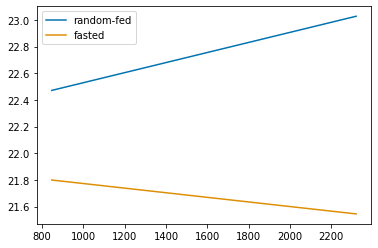

In [42]:
feature = 'l_557'
test = get_model_fits(feature, ogtt)

plt.plot(test['RBG'][0], test['RBG'][1], c=colors['RBG'], label='random-fed')
plt.plot(test['FBG'][0], test['FBG'][1], c=colors['FBG'], label='fasted')


for bg_type in ['RBG', 'FBG']:
    for animal in animals_used:
        plt.scatter()
    

plt.scatter()

plt.legend()